## Is there a difference in order quantity per purchasing region?

H_O : there is no difference in order quantities between regions

H_A : there is a difference in orders quantities between regions

In [129]:
import sqlite3
import pandas as pd
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [171]:
def get_table_names(conn):
    """ Function takes in a DB and returns a list of table names"""
    res = conn.execute("""select name 
                       from sqlite_master 
                       where type='table';""").fetchall()
    return [r[0] for r in res]


def create_region_dicts(regions_lst):
    """Function takes in a list of regions found in 'ord_reg_quant' datafram. 
        Returns two dicts (keys are region_lst descriptors):
            region_df_dict = pd.DataFrame per region with columns [Id, ShipRegion, Quantity]
                            and row per order shipped to that region.
            region_stats = pd.Series per region with descritive stats (max, min, mean, std, etc.)
                            as column names. Rows are order Id and quantity."""
    region_df_dict = {}
    region_stats = {}
    for region in regions_lst:
        region_df = ord_reg_quant.loc[ord_reg_quant['ShipRegion'] == region].sort_values('Quantity')
        region_df_dict[region] = region_df
        region_stats[region] = region_df['Quantity'].describe().transpose()
    return region_df_dict, region_stats


def plot_sns_dist_byRegion(ship_regions_lst):
    """Plots overlapping Seaborn distplots (Histogram and KDE) for each region passed in"""
    plt.figure(figsize=(16,12))
    for region in ship_regions_lst:
        sns.distplot(region_df_dict[region][['Quantity']], bins=50, label=region)
    plt.legend()
    plt.title('Quantities per Order by Region')
    plt.xlabel('Product Quantity per Order')
    plt.ylabel('Probability')
    
def plot_sns_dist_byRegion_NO_HIST(ship_regions_lst):
    """Plots overlapping Seaborn KDE for each region passed in"""
    plt.figure(figsize=(16,12))
    for region in ship_regions_lst:
        sns.distplot(region_df_dict[region][['Quantity']], bins=50, label=region, hist=False)
    plt.legend()
    plt.title('Quantities per Order by Region')
    plt.xlabel('Product Quantity per Order')
    plt.ylabel('Probability')
        
def plot_sns_dist_byRegion_seperate(ship_regions_lst):
    """Plots seperate Seaborn distplots for each region passed in"""
    fig, axes = plt.subplots(ncols=1, nrows=9, figsize=(8,25))
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    for i, region in enumerate(ship_regions_lst):
        ax = axes[i]
        sns.distplot(region_df_dict[region][['Quantity']], bins=50, label=region, ax=ax)
        ax.set_title('Quantities per Order:{}'.format(region))
        ax.set_xlabel('Product Quantity per Order')
        ax.set_ylabel('Probability')
        
def test_for_normality(arr, confidence=0.95):
    t, p = scs.shapiro(arr)
    if p <= 1 - confidence:
        print("reject the null")
        return False
    print("fail to reject the null")
    return True

def test_for_normality(regions_lst, confidence=0.95):
    """ Tests regions in list for normalcy using Shapiro's test. 
            'The Shapiro-Wilk test tests the null hypothesis that the
            data was drawn from a normal distribution.'
        Prints results and returns list of normal and not_normal region names"""
    normal = []
    not_normal = []
    for region in regions_lst:
        t, p = scs.shapiro(region_df_dict[region]['Quantity'])
        if p <= 1 - confidence:
            not_normal.append(region)
            print(region,": reject to the null (not normal)\n")
        else:
            normal.append(region)
            print(region,":fail to reject the null (normal)\n")
    return normal, not_normal


In [5]:
# Connect to database and print list of table names
conn = sqlite3.connect('/Users/annadangela/FLatiron/mod02/dsc-case-study-hypothesis-testing/data/northWind.sqlite')
cur = conn.cursor()
get_table_names(conn)

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [11]:
# import order table, reduce to order Id and Ship to Region
orders = pd.read_sql("""select * from 'Order';""", conn)[['Id', 'ShipRegion']]
orders.head()

,Id,ShipRegion
0,10248,Western Europe
1,10249,Western Europe
2,10250,South America
3,10251,Western Europe
4,10252,Western Europe


In [26]:
# number of unique orders, 830
n = orders['Id'].nunique()
n

830

In [8]:
# import order detail table, modify to sum quantity per unique order Id
ord_quant = pd.read_sql("""select * from OrderDetail;""", conn)
ord_quant = ord_quant.groupby(by='OrderId')[['Quantity']].agg(sum).reset_index().rename(columns={'OrderId':'Id'}) # len 830 unique orders
ord_quant.head()

,Id,Quantity
0,10248,27
1,10249,49
2,10250,60
3,10251,41
4,10252,105


In [12]:
# Merge order and order detail table 
ord_reg_quant = pd.merge(orders[['Id', 'ShipRegion']], ord_quant, on="Id")
ord_reg_quant.sort_values('ShipRegion').head()
#replace space with underscore
ord_reg_quant.ShipRegion = ord_reg_quant.ShipRegion.str.replace(" ", "_")
ord_reg_quant.head()

,Id,ShipRegion,Quantity
0,10248,Western_Europe,27
1,10249,Western_Europe,49
2,10250,South_America,60
3,10251,Western_Europe,41
4,10252,Western_Europe,105


In [34]:
# summary of regional ordering stats for all 9 regions, add mean quantity per order
ship_reg_quant = ord_reg_quant.groupby('ShipRegion').agg({'Id': 'nunique', 'Quantity': 'sum' }).reset_index().rename(columns={'Id': 'Num_orders', 'Quantity': 'Num_items' })
ship_reg_quant['Mean_quant_order'] = ship_reg_quant['Num_items']/ship_reg_quant['Num_orders']
ship_reg_quant['Mean'] = ship_reg_quant[]
ship_reg_quant

,ShipRegion,Num_orders,Num_items,Mean_quant_order
0,British_Isles,75,4426,59.013333
1,Central_America,28,1025,36.607143
2,Eastern_Europe,7,205,29.285714
3,North_America,152,11314,74.434211
4,Northern_Europe,55,3405,61.909091
5,Scandinavia,28,1046,37.357143
6,South_America,145,7522,51.875862
7,Southern_Europe,64,2073,32.390625
8,Western_Europe,276,20301,73.554348


In [35]:
# create list of region names to be used in iteration
regions_lst = list(ord_reg_quant['ShipRegion'].unique())
regions_lst

['Western_Europe',
 'South_America',
 'Central_America',
 'North_America',
 'Northern_Europe',
 'Scandinavia',
 'Southern_Europe',
 'British_Isles',
 'Eastern_Europe']

In [36]:
# create two dictionaries per region (see function def above)
region_df_dict, region_stats = create_region_dicts(regions_lst)

In [37]:
# keys are region names, call on 'region_df_dict[<region_name>][<column_name>]' to print pd.DataFrame of order Id and quantity per order
region_df_dict

{'Western_Europe':         Id      ShipRegion  Quantity
 519  10767  Western_Europe         2
 261  10509  Western_Europe         3
 490  10738  Western_Europe         3
 47   10295  Western_Europe         4
 595  10843  Western_Europe         4
 ..     ...             ...       ...
 597  10845  Western_Europe       245
 410  10658  Western_Europe       255
 742  10990  Western_Europe       256
 267  10515  Western_Europe       286
 647  10895  Western_Europe       346
 
 [276 rows x 3 columns], 'South_America':         Id     ShipRegion  Quantity
 534  10782  South_America         1
 283  10531  South_America         2
 652  10900  South_America         3
 771  11019  South_America         5
 650  10898  South_America         5
 ..     ...            ...       ...
 213  10461  South_America       128
 237  10485  South_America       130
 791  11039  South_America       132
 638  10886  South_America       145
 124  10372  South_America       164
 
 [145 rows x 3 columns], 'Central_Ame

In [74]:
# keys are region names, stats are transpose as columns, access as 'region_stats[<stat_type>]'
region_stats

{'Western_Europe': count    276.000000
 mean      73.554348
 std       58.540062
 min        2.000000
 25%       31.750000
 50%       55.000000
 75%      105.000000
 max      346.000000
 Name: Quantity, dtype: float64, 'South_America': count    145.000000
 mean      51.875862
 std       33.024377
 min        1.000000
 25%       25.000000
 50%       48.000000
 75%       75.000000
 max      164.000000
 Name: Quantity, dtype: float64, 'Central_America': count    28.000000
 mean     36.607143
 std      20.216127
 min       6.000000
 25%      23.000000
 50%      30.000000
 75%      51.250000
 max      83.000000
 Name: Quantity, dtype: float64, 'North_America': count    152.000000
 mean      74.434211
 std       63.182032
 min        2.000000
 25%       28.250000
 50%       59.000000
 75%      100.750000
 max      330.000000
 Name: Quantity, dtype: float64, 'Northern_Europe': count     55.000000
 mean      61.909091
 std       36.383387
 min        5.000000
 25%       32.500000
 50%       60

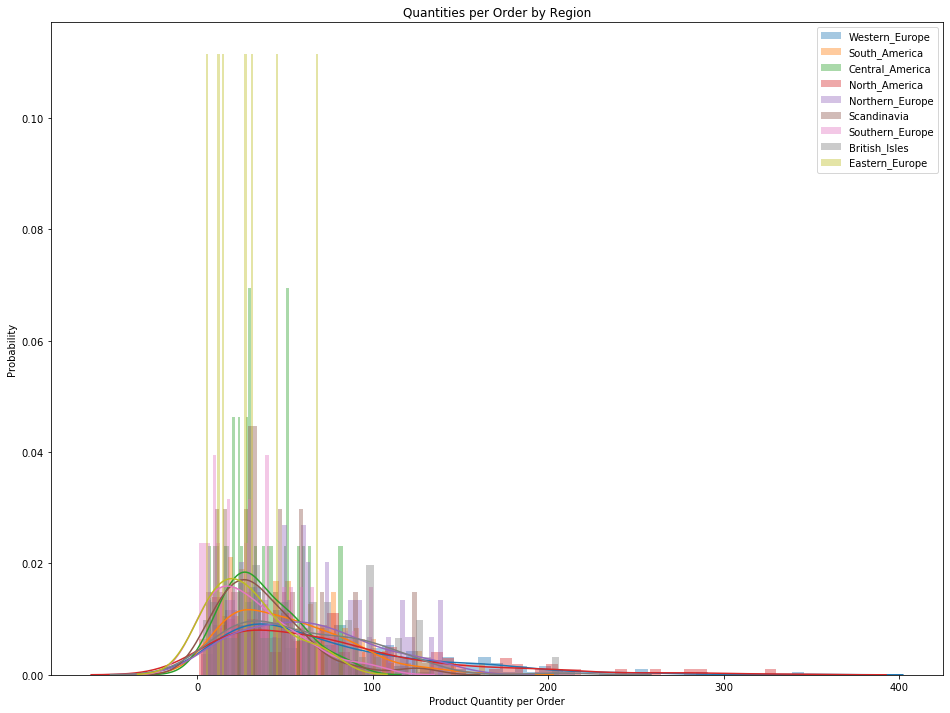

In [105]:
# Plot distplots of item quantity ordered per order, group by Region
plot_sns_dist_byRegion(ship_regions_lst)

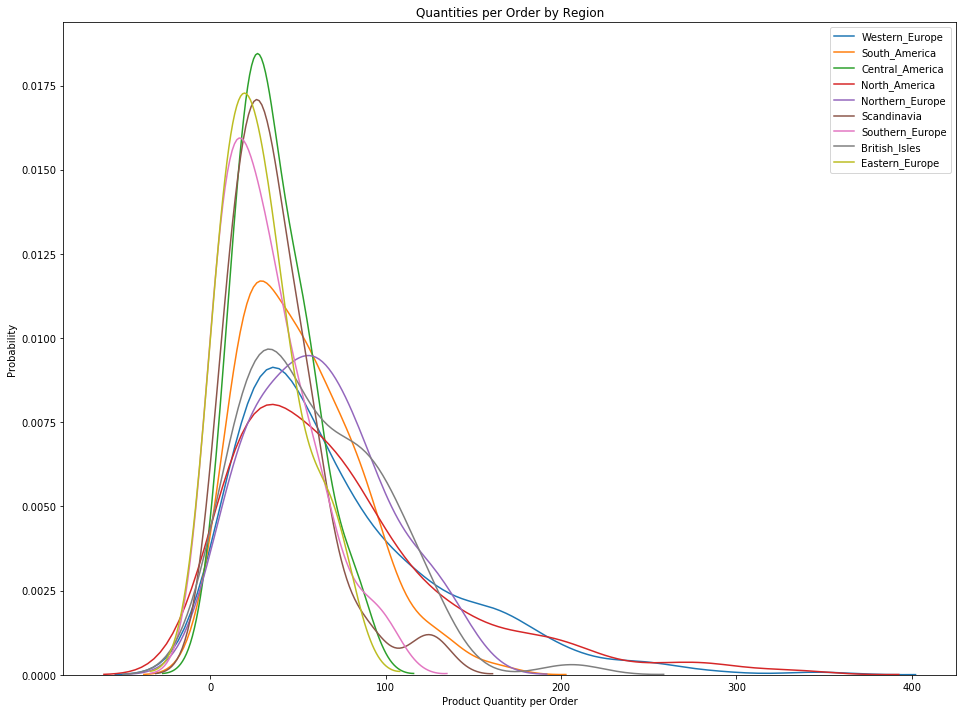

In [172]:
# Remove noise of hist for just PDF plot:
plot_sns_dist_byRegion_NO_HIST(ship_regions_lst)

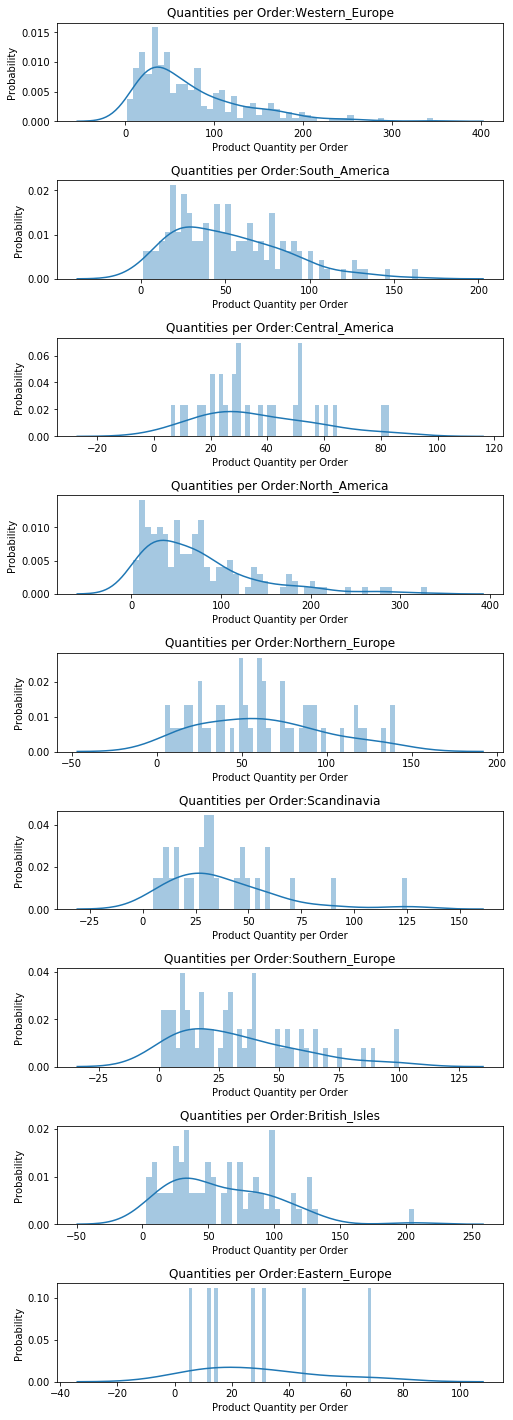

In [170]:
#Plot seperately by region for better comparison
plot_sns_dist_byRegion_seperate(ship_regions_lst)

Text(0, 0.5, 'Probability Density Function')

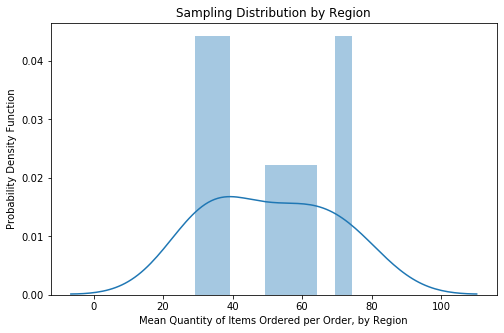

In [46]:
# plot sampling distribution of mean quantity items ordered per order, per region (9 bins, one per region)
plt.figure(figsize=(8,5))
sns.distplot(ship_reg_quant['Mean_quant_order'], bins=9)
plt.title('Sampling Distribution by Region')
plt.xlabel('Mean Quantity of Items Ordered per Order, by Region')
plt.ylabel('Probability Density Function')

In [68]:
# test for normality using Shapiro's test: 'The Shapiro-Wilk test tests the null hypothesis that the
                                            # data was drawn from a normal distribution.'
alpha = 0.05
confidence = 1 - alpha # 0.95
normal, not_normal = test_for_normality(regions_lst, confidence=confidence)

Western_Europe : reject the null (not normal)

South_America : reject the null (not normal)

Central_America :fail to reject the null (normal)

North_America : reject the null (not normal)

Northern_Europe :fail to reject the null (normal)

Scandinavia : reject the null (not normal)

Southern_Europe : reject the null (not normal)

British_Isles : reject the null (not normal)

Eastern_Europe :fail to reject the null (normal)



In [174]:
# Are limited in significance tests because not all data is normal, 6 are not
print("Normal:", normal)
print("Not normal:",not_normal)

Normal: ['Central_America', 'Northern_Europe', 'Eastern_Europe']
Not normal: ['Western_Europe', 'South_America', 'North_America', 'Scandinavia', 'Southern_Europe', 'British_Isles']


# FUTURE WORK

## ANOVA Test

H_O : there is no difference in orders between regions, mus = x_bars

H_A : there is a difference in orders between regions, mus != X_bars